In [790]:
import kagglehub # Чтобы импортировать датасет с kaggle
import os # Чтобы загрузить датасет с kaggle
import pandas as pd # Таблицы и временные ряды
import numpy as np # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Графика
%matplotlib inline
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import seaborn as sns # Еще графика
import sklearn # Алгоритмы МО

**Powerlifting Database**

0. *Описание задачи*

В датасете представлена информация о соревнованиях по пауэрлифтингу и об участниках данных соревнований.
Предположим, у вас есть знакомый, который хочет попробовать себя на подобных соревнованиях. Он усердно готовился, и уверен, что выступит на уровне профессионалов. Вы хотите предсказать: **какое место он займет на соревнованиях различного уровня на основании своих тренировочных весов?**

1. *Загружаем данные*

In [791]:
path = kagglehub.dataset_download("open-powerlifting/powerlifting-database")
print("Path to dataset files:", path)
print("Files in dataset:", os.listdir(path))

filepath = path + "/openpowerlifting.csv"
print("Path to main dataset:", filepath)

ds = pd.read_csv(filepath)

Using Colab cache for faster access to the 'powerlifting-database' dataset.
Path to dataset files: /kaggle/input/powerlifting-database
Files in dataset: ['openpowerlifting-2024-01-06-4c732975.csv', 'openpowerlifting.csv']
Path to main dataset: /kaggle/input/powerlifting-database/openpowerlifting.csv


/tmp/ipython-input-4226167.py:8: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = pd.read_csv(filepath)


Датасет содержит информацию об 412574 участниках различных соревнований. Для участников указаны: пол, тип соревнования, экипировка, возраст, возрастной класс, дивизион, вес, вес в 4 попытках в приседаниях (не на всех соревнованиях позволено делать 4 попытки, чаще всего это 3 попытки, так что в датасете появляются пропущенные значения), лучший вес в приседаниях, вес в 4 попытках в жиме лежа (аналогично с пропущенными значениями), лучший вес в жиме лежа, вес в 4 попытках в становой тяге (аналогично с пропущенными значениями), лучший вес в становой тяге, общий вес на соревнованиях, место, которое занял участник на соревновании, коэффициент Вилкса (https://en.wikipedia.org/wiki/Wilks_coefficient), коэффициент Маккалоха (https://wsf-federation.ru/files/McCulloch_coefficients_WRPF.pdf), коэффициент Глоссбренера (https://worldpowerliftingcongress.com/wp-content/uploads/2015/02/Glossbrenner.htm), очки IPF (https://www.ipfpointscalculator.com/), был ли участник протестирован на допинг, страна участника, федерация спорта, которая проводила соревнование, дата выступления, страна, в которой проводилось соревнование, штат, в котором проводилось соревнование, название соревнования (под каким заголовком проводилось: чемпионат мира, Европы и тд).

*Посмотрим на данные:*

1423354 записей (кол-во строк), 37 признаков(кол-во столбцов)

In [792]:
ds.shape

(1423354, 37)

In [793]:
ds.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


Выведем первые 5 столбцов. Уже видны первые проблемы с пропущенными значениями: NaN в tested, в country и в значениях поднятых весов. Обратите внимание также на - в поднятых весах. Он означает, что попытка поднять вес была провалена. Необходимо обработать подобные значения. Можно либо зачесть эти отрицательные значения, как успешные попытки (что будет, в общем-то, нечестно), либо взять на заметку, что надо обрабатывать отрицательные значения как проваленные попытки, которые влияют на место в соревновании.

Послдение 5 строк:

In [794]:
ds.tail()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
1423349,Marian Cafalik,M,SBD,Raw,60.5,60-64,Masters 2,73.5,74,160.0,...,438.27,316.52,469.67,Yes,NaN,PZKFiTS,2017-04-01,Poland,NaN,Polish Classic Powerlifting Cup
1423350,Marian Piwowarczyk,M,SBD,Raw,55.5,55-59,Masters 2,63.5,66,90.0,...,372.60,295.66,423.03,Yes,Poland,PZKFiTS,2017-04-01,Poland,NaN,Polish Classic Powerlifting Cup
1423351,Andrzej Bryniarski,M,SBD,Raw,62.5,60-64,Masters 2,94.4,105,140.0,...,382.36,264.22,378.84,Yes,NaN,PZKFiTS,2017-04-01,Poland,NaN,Polish Classic Powerlifting Cup
1423352,Stanisław Goroczko,M,SBD,Raw,63.5,60-64,Masters 2,80.8,83,-165.0,...,NaN,NaN,NaN,Yes,NaN,PZKFiTS,2017-04-01,Poland,NaN,Polish Classic Powerlifting Cup
1423353,Jan Sowa,M,SBD,Raw,70.5,70-74,Masters 2,82.0,83,-115.0,...,NaN,NaN,NaN,Yes,NaN,PZKFiTS,2017-04-01,Poland,NaN,Polish Classic Powerlifting Cup


У нас имеются следующие признаки:

* Имя
* Пол
* Тип соревнования - SBD означает классическое троеборье, BD - только жим лежа и становая тяга
* Экипировка - RAW - без экипировки, Wraps - специальные бинты для кистей, single-ply - один слой поддерживающей экипировки (например только наколенники), multi-ply - несколько слоев поддерживающей экипировки
* Возраст
* Класс, в котором выступают (по возрасту). Разные федерации могут разбивать на разные возрастные группы
* Дивизион
* Вес участника
* Вес, в котором соревновался участник. Вес участника в момент взвешивания не больше, чем класс, в котором он участвовал.
* 4 попытки приседаний - могут быть проваленные, и успешные, либо пропущенные (4 попытка дается для попыток на рекорд, так что обычно всего 3 попытки)
* Лучший вес за 3 попытки приседаний, учитывается в общем весе
* 4 попытки жима
* Лучший вес за 3 попытки жима лежа, учитывается в общем весе
* 4 попытки становой тяги, учитывается в общем весе
* Общая сумма поднятого веса, сумма из трех слагаемых: лучшее приседание, лучший жим лежа, лучшая становая тяга
* Место, занятое участником на соревновании
* [Коэффициент Вилкса](https://en.wikipedia.org/wiki/Wilks_coefficient)
* [Коэффициент Маккалоха](https://wsf-federation.ru/files/McCulloch_coefficients_WRPF.pdf)
* [Коэффициент Глоссбренера](https://worldpowerliftingcongress.com/wp-content/uploads/2015/02/Glossbrenner.htm)
* [Очки IPF](https://www.powerlifting.sport/rulescodesinfo/ipf-formula.html), [калькулятор очков](https://www.ipfpointscalculator.com/)
* Проверяли ли участника на допинг
* Страна, из которой участник
* Федерация спорта, которая проводила соревнование
* Дата
* Страна, в которой проводилось соревнование
* Штат, в котором проводилось соревнование (характерно для Америки)
* Название соревнования

In [795]:
ds.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division',
       'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
       'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
       'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg',
       'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks',
       'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country',
       'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName'],
      dtype='object')

In [796]:
ds.index

RangeIndex(start=0, stop=1423354, step=1)

Проверим типы всех признаков:

In [797]:
columns = ds.columns
for col in columns:
  print(col, ds[col].dtype)

Name object
Sex object
Event object
Equipment object
Age float64
AgeClass object
Division object
BodyweightKg float64
WeightClassKg object
Squat1Kg float64
Squat2Kg float64
Squat3Kg float64
Squat4Kg float64
Best3SquatKg float64
Bench1Kg float64
Bench2Kg float64
Bench3Kg float64
Bench4Kg float64
Best3BenchKg float64
Deadlift1Kg float64
Deadlift2Kg float64
Deadlift3Kg float64
Deadlift4Kg float64
Best3DeadliftKg float64
TotalKg float64
Place object
Wilks float64
McCulloch float64
Glossbrenner float64
IPFPoints float64
Tested object
Country object
Federation object
Date object
MeetCountry object
MeetState object
MeetName object


Надо переназначить типы категориальным и текстовому признаку.

In [798]:
for col in columns:
  if ds[col].dtype == 'object':
    ds[col] = ds[col].astype('category')
# Имя можно сделать string
ds['Name'] = ds['Name'].astype('string')
for col in columns:
  print(col, ds[col].dtype)

Name string
Sex category
Event category
Equipment category
Age float64
AgeClass category
Division category
BodyweightKg float64
WeightClassKg category
Squat1Kg float64
Squat2Kg float64
Squat3Kg float64
Squat4Kg float64
Best3SquatKg float64
Bench1Kg float64
Bench2Kg float64
Bench3Kg float64
Bench4Kg float64
Best3BenchKg float64
Deadlift1Kg float64
Deadlift2Kg float64
Deadlift3Kg float64
Deadlift4Kg float64
Best3DeadliftKg float64
TotalKg float64
Place category
Wilks float64
McCulloch float64
Glossbrenner float64
IPFPoints float64
Tested category
Country category
Federation category
Date category
MeetCountry category
MeetState category
MeetName category


Также важно обратить внимание: решается задача регрессии. Мы хотим предсказать место участника, но сейчас признак 'Place' является категориальным. Давайте посмотрим, как выглядят значения в этом признаке:

In [799]:
ds['Place'].cat.categories

Index(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       ...
       '94', '95', '96', '97', '98', '99', 'DD', 'DQ', 'G', 'NS'],
      dtype='object', length=124)

Видно, что если убрать значения 'DQ', 'DD', 'G' и 'NS', то можно перевести данный признак из типа 'category' в тип 'int64'.
Давайте для начала узнаем, что означают аббревиатуры:


*   DQ - дисквалифицирован
*   DD - дисквалифицирован за допинг
*   G - выступает как гость, не участвует в общем зачете
*   NS - не явился

В итоге очевидно, что данные аббревиатуры можно заменить просто нулем и получить числовой признак.
Давайте так и сделаем.


In [800]:

ds['Place'] = ds['Place'].replace(['DQ', 'DD', 'G', 'NS'], '0')
ds['Place'] = ds['Place'].astype('int64')
ds['Place']

/tmp/ipython-input-3199019541.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ds['Place'] = ds['Place'].replace(['DQ', 'DD', 'G', 'NS'], '0')


,Place
0,4
1,2
2,1
3,3
4,3
...,...
1423349,4
1423350,5
1423351,6
1423352,0


Также есть проблема с признаком 'Tested'. Дело в том, что он принимает только 2 значения: 'Yes' и NaN.
Давайте заменим 'Yes' на 1, а NaN на 0.

In [801]:
ds['Tested'] = ds['Tested'].astype('str')
ds['Tested'] = ds['Tested'].replace('nan', 'No')
ds['Tested'] = ds['Tested'].astype('category')
ds['Tested']

,Tested
0,No
1,No
2,No
3,No
4,No
...,...
1423349,Yes
1423350,Yes
1423351,Yes
1423352,Yes




Для предсказания места участника на соревнованиях можно не использовать следующие признаки:
- Дату
- Страну, в которой проводилось соревнование
- Штат (потому что он зависит от страны)
- Страну, из которой участник
- Название соревнования
- В моем датасете ничего почему-то не зависит от коэффициентов, давайте их тоже уберем
- Федерацию, которая проводила соревнование
- Четвертые попытки в соревнованиях, они предназначены для установки рекордов

In [802]:
data = ds.drop(['Date', 'MeetCountry', 'MeetState','Country', 'Federation', 'MeetName', 'Squat4Kg',
                  'Bench4Kg', 'Deadlift4Kg', 'Wilks', 'McCulloch', 'Glossbrenner', 'IPFPoints'], axis=1)
data.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division',
       'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
       'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg',
       'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Tested'],
      dtype='object')

3. *Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу). Интерпретировать*

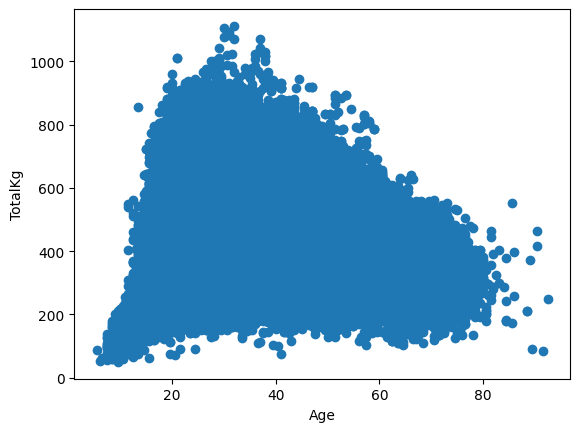

In [803]:
# Интересно посмотреть:
# Как зависит сумма поднятых кг от возраста участника
# Очевидно, что место в соревновании напрямую зависит от поднятых кг
# Оставим только протестированных на допинг участников
# Только тех, кто поднимал без экипировки
# Только тех, кто участвовал в троеборье (иначе очевидно, что сумма будет меньше)
# И непустые
# Иначе очень много записей
new_ds = data.dropna()
filter_ds = new_ds[new_ds['Tested']== 'Yes']
filter_ds = filter_ds[filter_ds['Equipment'] == 'Raw']
filter_ds = filter_ds[filter_ds['Event'] == 'SBD']

plt.scatter(filter_ds['Age'], filter_ds['TotalKg'])
plt.xlabel('Age')
plt.ylabel('TotalKg')
pass

Интересно видеть, что и после 80 лет люди поднимают веса. Посмотрим на суммы мужчин (считаем, что наш участник из задачи - мужчина), которые заняли 1 место в открытом дивизионе, в классическом троеборье, при этом не используя никакой экипировки:

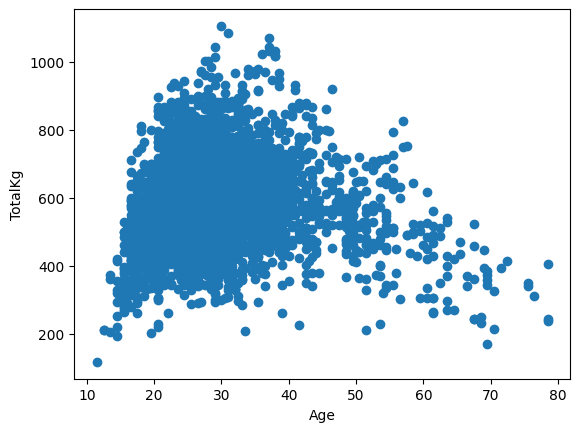

In [804]:
filter_ds = new_ds[new_ds['Tested']== 'Yes']
filter_ds = filter_ds[filter_ds['Equipment'] == 'Raw']
filter_ds = filter_ds[filter_ds['Event'] == 'SBD']
filter_ds = filter_ds[filter_ds['Place'] == 1]
filter_ds = filter_ds[filter_ds['Division'] == 'Open']
filter_ds = filter_ds[filter_ds['Sex'] == 'M']

plt.scatter(filter_ds['Age'], filter_ds['TotalKg'])
plt.xlabel('Age')
plt.ylabel('TotalKg')
pass

Видно, что даже в троеборье кто-то проваливал свои попытки, и все равно занимал первое место, что даже удивительно. Датасет действительно очень большой, и поэтому стоит быть аккуратнее с его визуализацией, много нюансов.

Видно, что основная масса мужчин-участников в возрасте от 15 до 40 лет. В верхней части графика, TotalKg > 1000 наблюдаются интересные выбросы. Так как здесь выбраны только участники, занявшие 1 место, очевидно, что они не были дисквалифицированы за допинг. Видимо, эти участники - гении от мира пауэрфлифтинга. Возможно это ошибки в данных.
Справа тоже выбросы - пожилые участники сореванований. И такое бывает.

Давайте все-таки не будем так сильно ограничивать нашего участника. Вдруг он пользуется экипировкой? При этом оставим дивизион 'Open'. Все-таки впервые участвует. И так как соревнования чаще всего разделяются по половому признаку, пол в нашей задаче регрессии мы тоже не будем учитывать. И останемся в рамках классического троеборья. Отхождения от троеборья к двоеборью сильно влияет на TotalKg.

In [805]:
data = data[data['Division'] == 'Open']
data = data[data['Sex'] == 'M']
data = data[data['Event'] == 'SBD']
data.shape

(172425, 24)

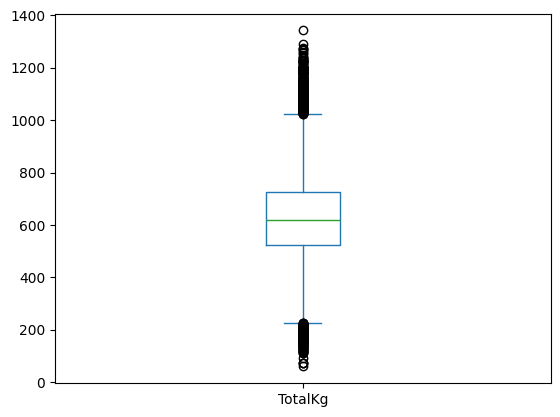

In [806]:
# Найдем выбросы:
data['TotalKg'].plot(kind='box')
pass

<Axes: >

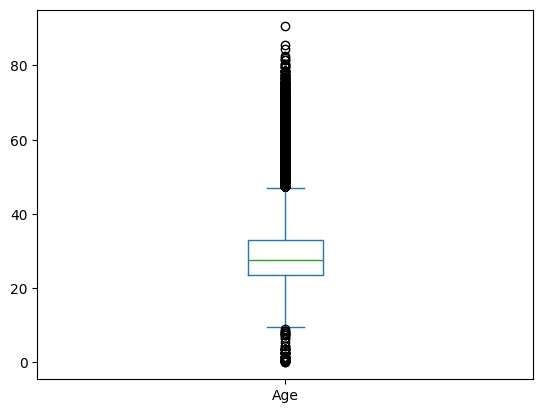

In [807]:
data['Age'].plot(kind='box')

In [808]:
data.quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995], numeric_only=True)

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place
0.005,15.5,51.8000,-375.0,-400.0,-415.0,55.00,-260.0,-284.9925,-300.0,48.95795,-317.5,-355.0,-375.0000,82.50,267.50,0.0
0.010,16.0,52.0000,-355.0,-377.5,-395.0,80.00,-240.0,-260.0000,-280.0,62.50000,-300.0,-340.0,-365.0000,115.00,300.00,0.0
0.050,18.5,59.7800,-280.0,-315.0,-340.0,130.00,-170.0,-205.0000,-227.5,90.00000,-210.0,-297.5,-330.0000,160.00,397.50,0.0
0.100,20.5,66.7000,-225.0,-272.5,-303.5,150.00,-120.0,-172.5000,-202.5,102.06000,137.5,-262.5,-307.5000,181.44,445.00,1.0
0.500,27.5,89.7500,192.5,190.0,152.5,225.00,135.0,130.0000,-100.0,150.00000,222.5,220.0,-185.0000,242.50,620.00,2.0
0.900,39.0,120.0000,300.0,305.0,300.0,317.52,200.0,205.0000,197.5,212.50000,295.0,300.0,282.5000,305.00,822.50,8.0
0.950,44.0,127.5000,330.0,340.0,332.5,345.00,225.0,227.5000,222.5,231.33000,310.0,320.0,307.5000,322.50,882.50,10.0
0.990,55.5,152.5612,380.0,390.0,390.0,397.50,267.5,272.5000,270.0,275.00000,340.0,352.5,347.5000,353.00,997.50,17.0
0.995,61.0,162.0000,395.0,410.0,410.0,415.00,285.0,292.5000,290.0,295.00000,350.0,362.5,360.6775,365.00,1031.92,20.0


99% значений 'TotalKg' находится в диапазоне от 267.5 до 1032 кг.
99% значений 'Age' находится в диапазоне от 15.5 до 61 года.
Удалим все строки таблицы, в которых 'TotalKg' и 'Age' выходят за пределы квантилей 0.005 и 0.095.
Трогать выбросы в 'BodyweightKg' и в 'Places' я трогать не буду. 'Places' важны все. Наш участник может занять и 50 место и 105. А насчет веса: все люди разные и все выступают на подобных соревнованиях. По квантилям возраста видно, что у всех приемлемые числа в весе.

In [809]:
rows_to_drop = data[
    (data['TotalKg'] < data['TotalKg'].quantile(0.005)) |
    (data['TotalKg'] > data['TotalKg'].quantile(0.995)) |
    (data['Age'] < data['Age'].quantile(0.005)) |
    (data['Age'] > data['Age'].quantile(0.995))
].index
data = data.drop(rows_to_drop)

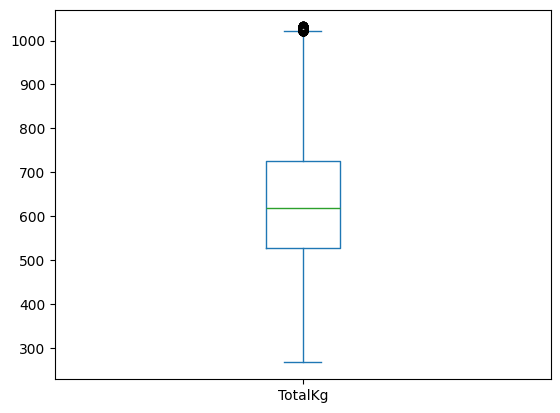

In [810]:
data['TotalKg'].plot(kind='box')
pass

<Axes: >

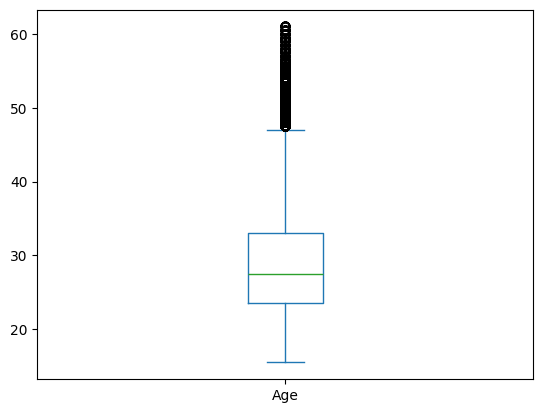

In [811]:
data['Age'].plot(kind='box')

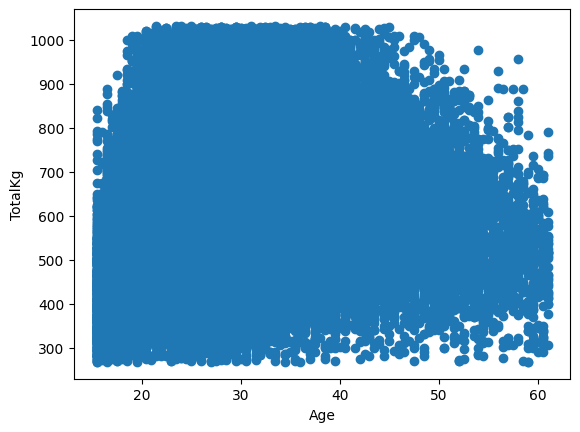

In [812]:
plt.scatter(data['Age'], data['TotalKg'])
plt.xlabel('Age')
plt.ylabel('TotalKg')
pass

In [813]:
data.shape

(169843, 24)

Выглядит немного лучше и не так кучно. Видно, что в соревнованиях принимают участие мужчины самых разных возрастов, и поднимают они самые разные веса (разумеется это зависит от подготовленности участника)

Теперь посмотрим на основные характеристики:

In [814]:
data.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place
count,116299.000000,167932.000000,60678.000000,59719.000000,57412.000000,163599.000000,58923.000000,58142.000000,56014.000000,161392.000000,58301.000000,56880.000000,53380.000000,159941.000000,157709.000000,169843.000000
mean,28.880472,91.565421,138.240119,99.444520,17.196945,229.383810,106.665950,70.240286,-12.859550,153.308884,197.025746,135.229736,-26.596459,243.161281,627.961549,3.328745
std,7.564587,20.906311,185.411337,221.835417,249.479522,68.379127,112.476796,146.989132,167.106012,45.872803,128.448105,209.746127,256.301379,51.232134,141.754647,3.617861
min,15.500000,44.000000,-485.000000,-530.000000,-530.000000,-462.500000,-392.500000,-400.000000,-539.780000,-365.000000,-405.000000,-427.500000,-587.500000,-347.500000,267.500000,0.000000
25%,23.500000,75.000000,140.000000,-152.500000,-232.500000,185.000000,100.000000,-97.500000,-160.000000,124.740000,185.000000,160.000000,-265.000000,210.000000,527.500000,1.000000
50%,27.500000,89.800000,195.000000,190.000000,155.000000,226.800000,135.000000,130.000000,-100.000000,150.000000,224.530000,220.000000,-190.000000,244.940000,620.000000,2.000000
75%,33.000000,103.800000,250.000000,250.000000,235.000000,272.500000,170.000000,170.000000,150.000000,180.000000,260.000000,265.000000,235.000000,275.000000,725.000000,4.000000
max,61.000000,232.700000,480.000000,498.950000,517.100000,571.530000,369.680000,392.360000,385.550000,392.360000,400.000000,430.000000,457.500000,457.500000,1031.920000,59.000000


Итак мы видим, что отрицательные значения портят характеристики датасета. Пока я выполняла данное упражнение, я размышляла над тем, что мне сделать с проваленными попытками. Если инвертировать знак, то будет совершенно нечестно - ведь данные попытки были провалены, и это влияет на место в соревновании. Если поставить их нулем - они тоже повлияют на характеристики датасета. Сделать их пропущенными - тоже нелогично. Мы потом пропущенные будем восстанавливать.

Поэтому давайте сделаем следующее: введем для каждой попытки признак проваленной/непроваленной попытки. Да, это добавит нам еще 12 признаков. Но они будут простые категориальные признаки: да/нет.
Теперь попытка всегда будет положительным числом, просто добавится признак проваленной/непроваленной попытки

Дальше, после коррекции попыток все сломается, так что введу матрицу корреляции сейчас:

In [815]:
corr_mat = data.corr(numeric_only=True)
corr_mat

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place
Age,1.000000,0.164743,0.020140,0.017225,0.006924,0.077803,0.048514,0.011249,-0.028929,0.130019,0.048245,0.029304,-0.003320,0.079465,0.113658,-0.068451
BodyweightKg,0.164743,1.000000,0.085935,0.075980,0.038794,0.459860,0.135019,0.075468,-0.009730,0.509347,0.167599,0.084083,-0.005437,0.472996,0.565622,-0.077893
Squat1Kg,0.020140,0.085935,1.000000,0.121598,0.050849,0.214950,0.110052,0.072490,0.049524,0.152848,0.108034,0.049528,0.005084,0.182985,0.213047,0.053978
Squat2Kg,0.017225,0.075980,0.121598,1.000000,0.128801,0.104804,0.083551,0.100745,0.078668,0.059596,0.083101,0.099100,0.070357,0.093755,0.102381,0.008868
Squat3Kg,0.006924,0.038794,0.050849,0.128801,1.000000,0.020713,0.049364,0.090306,0.106497,-0.010028,0.041819,0.096262,0.127991,0.007125,0.013186,-0.011931
Best3SquatKg,0.077803,0.459860,0.214950,0.104804,0.020713,1.000000,0.193056,0.095606,0.025182,0.742617,0.246295,0.007212,-0.175874,0.754502,0.964762,-0.053387
Bench1Kg,0.048514,0.135019,0.110052,0.083551,0.049364,0.193056,1.000000,0.084060,0.008043,0.278166,0.129717,0.053478,-0.010738,0.223205,0.267833,0.026087
Bench2Kg,0.011249,0.075468,0.072490,0.100745,0.090306,0.095606,0.084060,1.000000,0.110733,0.166118,0.081252,0.084794,0.053109,0.121306,0.143046,-0.005748
Bench3Kg,-0.028929,-0.009730,0.049524,0.078668,0.106497,0.025182,0.008043,0.110733,1.000000,0.070808,0.042022,0.080750,0.092976,0.040469,0.051865,-0.000434
Best3BenchKg,0.130019,0.509347,0.152848,0.059596,-0.010028,0.742617,0.278166,0.166118,0.070808,1.000000,0.221606,0.026573,-0.127011,0.654530,0.903926,-0.062607


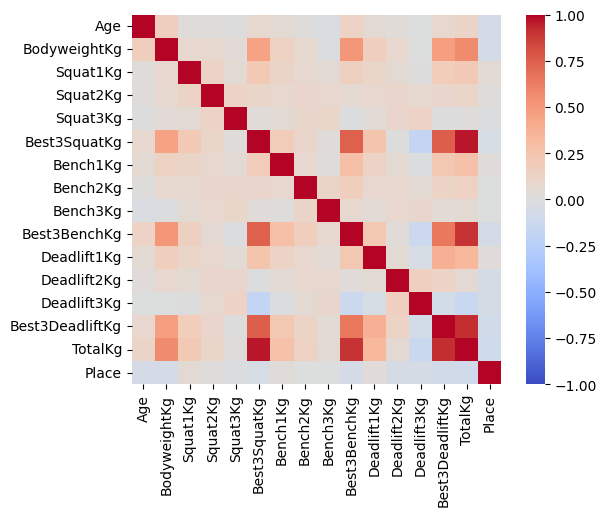

In [816]:
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm')
pass

По матрице корреляции видно, что место в соревновании зависит не столько от общего числа киллограмм, сколько от самих попыток поднятия весов в соревновании. Так что идею с использованием признаков проваленная/непроваленная попытка стоит отложить. Я использую положительные попытки только для того, чтобы выяснить характеристики. Оставим пока отрицательные попытки на месте.

In [817]:
positive_data = data
names = ['Squat', 'Bench', 'Deadlift']
for name in names:
  for i in range (1,4):
    full_name = name + str(i) + "Kg"
    positive_data[full_name] = data[full_name].abs()

In [818]:
names = ['Best3Squat', 'Best3Bench', 'Best3Deadlift']
for name in names:
  full_name = name + "Kg"
  positive_data[full_name] = data[full_name].abs()

In [819]:
positive_data.shape

(169843, 24)

Теперь пересмотрим наши числовые характеристики:

In [820]:
positive_data.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place
count,116299.000000,167932.000000,60678.000000,59719.000000,57412.000000,163599.000000,58923.000000,58142.000000,56014.000000,161392.000000,58301.000000,56880.000000,53380.000000,159941.000000,157709.000000,169843.000000
mean,28.880472,91.565421,221.771763,233.909974,241.068639,231.017055,148.533853,156.542861,161.224787,154.300121,229.859551,244.560853,252.815361,243.908394,627.961549,3.328745
std,7.564587,20.906311,65.608565,66.223398,66.488124,62.639867,44.341491,45.094331,45.780939,42.419321,49.823757,49.696865,49.809413,47.548221,141.754647,3.617861
min,15.500000,44.000000,0.300000,25.000000,30.000000,20.000000,7.500000,37.500000,40.000000,12.500000,17.500000,62.500000,75.000000,5.600000,267.500000,0.000000
25%,23.500000,75.000000,175.000000,185.000000,190.000000,185.000000,115.000000,122.500000,127.500000,125.000000,197.500000,210.000000,217.500000,210.920000,527.500000,1.000000
50%,27.500000,89.800000,215.000000,227.500000,235.000000,226.800000,142.500000,150.000000,155.000000,150.000000,230.000000,242.500000,250.000000,245.000000,620.000000,2.000000
75%,33.000000,103.800000,270.000000,280.000000,287.500000,272.500000,176.900000,185.000000,190.000000,180.000000,265.000000,280.000000,287.500000,275.000000,725.000000,4.000000
max,61.000000,232.700000,485.000000,530.000000,530.000000,571.530000,392.500000,400.000000,539.780000,392.360000,405.000000,430.000000,587.500000,457.500000,1031.920000,59.000000


Теперь можно интерпретировать характеристики:


*   Count - количество непустых значений в каждом столбце
*   Mean - среднее значение. В среднем, в соревнованиях участвуют мужчины 29 лет и сумма поднятых ими тяжестей составляет 628 кг. Если бы мы не оставили только троеборье, то среднее значение поднятного веса просело бы до 492 кг (именно из-за этого я и поставила фильтр на троеборье - уже напоролась на достаточно низкое среднее значение)
* Min - видно, что есть какие-то ошибочные значения, например кто-то присел с весом 0.3 кг. UPD: поправлять мы это не можем, это снова повлияет на корреляцию
* Std - стандартное отклонение - видно, что данные в попытках ОЧЕНЬ сильно разбросаны. Почему такое происходит - разный возраст, экипировка и тд.
Остальные характеристики интерпретируются очевидным образом.



In [821]:
positive_data['Place'].unique()

array([ 1,  2,  3,  5,  6,  4, 10, 13, 12,  8,  7, 11,  9, 14, 16, 17, 15,
       18,  0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 48])

2. *Разбить данные на обучающую и тестовую выборку*

Перенесла данный раздел сюда, потому что сначала стоило побороться с выбросами,
и немного отфильтровать мой датасет, так как он достаточно большой.
Напоминаю, что участник, которого мы оцениваем, мужчина, и выступает в открытом дивизионе в троеборье

Заполнение пропущенных значений производится на основе медианы или среднего. Из-за наличия у меня отрицательных значений, могут появиться проблемы. Давайте все-таки заменим их на 0. Да, это сломает корреляцию, но я уже не знаю, что мне делать с этими отрицательными значениями.

In [822]:
new_data = data
names = ['Squat', 'Bench', 'Deadlift']
for name in names:
  for i in range (1,4):
    full_name = name + str(i) + "Kg"
    new_data[full_name] = np.where(new_data[full_name] < 0, 0, new_data[full_name])

In [823]:
names = ['Best3Squat', 'Best3Bench', 'Best3Deadlift']
for name in names:
  full_name = name + "Kg"
  new_data[full_name] = np.where(new_data[full_name] < 0, 0, new_data[full_name])

In [824]:
X = new_data
# Давайте уберем еще 'Sex', 'Event' и 'Division' так как мы их отфильтровали
X = X.drop(['Sex', 'Event', 'Division'], axis = 1)
y = new_data['Place']
X.shape


(169843, 21)

In [825]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size = 0.25, random_state=42
                                    )

N_train, _ = X_train.shape
N_test, _ = X_test.shape

N_train, N_test

(127382, 42461)

4. *Заполнение пропущенных значений*


In [826]:
X_train.isna().sum()

,0
Name,0
Equipment,0
Age,40112
AgeClass,39546
BodyweightKg,1459
WeightClassKg,143
Squat1Kg,81882
Squat2Kg,82592
Squat3Kg,84340
Best3SquatKg,4722


In [827]:
X_test.isna().sum()

,0
Name,0
Equipment,0
Age,13432
AgeClass,13220
BodyweightKg,452
WeightClassKg,50
Squat1Kg,27283
Squat2Kg,27532
Squat3Kg,28091
Best3SquatKg,1522


In [828]:
from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
na_number = ['Age', 'BodyweightKg', 'Squat1Kg', 'Squat2Kg',
                     'Squat3Kg', 'Bench1Kg', 'Bench2Kg', 'Best3SquatKg',
                     'Best3BenchKg', 'Best3DeadliftKg',
                     'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                     'Deadlift3Kg', 'TotalKg']
imp_num.fit(X_train[na_number])

SimpleImputer(strategy='median')

In [829]:
X_train[na_number] = imp_num.transform(X_train[na_number])

In [830]:
from sklearn.impute import SimpleImputer
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
na_category = ['AgeClass', 'WeightClassKg']
imp_cat.fit(X_train[na_category])

SimpleImputer(strategy='most_frequent')

In [831]:
X_train[na_category] = imp_cat.transform(X_train[na_category])

In [832]:
X_train.isna().sum()

,0
Name,0
Equipment,0
Age,0
AgeClass,0
BodyweightKg,0
WeightClassKg,0
Squat1Kg,0
Squat2Kg,0
Squat3Kg,0
Best3SquatKg,0


In [833]:
X_train = X_train.drop(['AgeClass', 'WeightClassKg', 'Name'], axis=1)

5. *Бинаризация номинальных признаков*

In [834]:
X_train.select_dtypes(include=['category', 'object']).columns

Index(['Equipment', 'Tested'], dtype='object')

In [835]:
X_train['Equipment'].unique()

['Raw', 'Single-ply', 'Wraps', 'Multi-ply']
Categories (5, object): ['Multi-ply', 'Raw', 'Single-ply', 'Straps', 'Wraps']

'Tested' уже обработан, его можно заменить

In [836]:
X_train['Tested'] = X_train['Tested'].replace('Yes', '1')
X_train['Tested'] = X_train['Tested'].replace('No', '0')
X_train['Tested'] = X_train['Tested'].astype(int)


/tmp/ipython-input-1581219179.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train['Tested'] = X_train['Tested'].replace('Yes', '1')
/tmp/ipython-input-1581219179.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_train['Tested'] = X_train['Tested'].replace('No', '0')


Теперь с экипировкой:

In [837]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='if_binary')
enc.fit(X_train[['Equipment']])

OneHotEncoder(drop='if_binary')

In [838]:
dummies = pd.DataFrame(enc.transform(X_train[['Equipment']]).toarray(),
                       columns=enc.get_feature_names_out(), index=X_train.index)
dummies.head()

,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps
897892,0.0,1.0,0.0,0.0
1277912,0.0,0.0,1.0,0.0
894684,0.0,0.0,0.0,1.0
1006228,0.0,0.0,1.0,0.0
1014141,0.0,1.0,0.0,0.0


In [839]:
X_train = pd.concat((X_train, dummies), axis=1).drop(['Equipment'], axis=1)

In [840]:
X_train.head()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,...,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Tested,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps
897892,24.0,73.8,215.0,227.5,235.0,205.0,142.5,150.0,155.0,150.0,...,242.5,250.0,217.50,620.0,0,0,0.0,1.0,0.0,0.0
1277912,27.5,49.2,215.0,227.5,235.0,120.0,142.5,150.0,155.0,80.0,...,242.5,250.0,244.94,620.0,0,1,0.0,0.0,1.0,0.0
894684,30.0,107.5,215.0,227.5,235.0,240.0,142.5,150.0,155.0,192.5,...,242.5,250.0,307.50,740.0,1,0,0.0,0.0,0.0,1.0
1006228,27.5,73.4,215.0,227.5,235.0,100.0,142.5,150.0,155.0,100.0,...,242.5,250.0,305.00,505.0,14,1,0.0,0.0,1.0,0.0
1014141,28.5,72.3,160.0,170.0,175.0,175.0,125.0,132.5,137.5,132.5,...,220.0,230.0,230.00,537.5,1,1,0.0,1.0,0.0,0.0


Подготовим модель тоже:

In [841]:
X_test = X_test.drop(['AgeClass', 'WeightClassKg', 'Name'], axis=1)

In [842]:

imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
na_number = ['Age', 'BodyweightKg', 'Squat1Kg', 'Squat2Kg',
                     'Squat3Kg', 'Bench1Kg', 'Bench2Kg', 'Best3SquatKg',
                     'Best3BenchKg', 'Best3DeadliftKg',
                     'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                     'Deadlift3Kg', 'TotalKg']
imp_num.fit(X_test[na_number])

X_test[na_number] = imp_num.transform(X_test[na_number])

imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


X_test['Tested'] = X_test['Tested'].replace('Yes', '1')
X_test['Tested'] = X_test['Tested'].replace('No', '0')
X_test['Tested'] = X_test['Tested'].astype(int)

enc = OneHotEncoder(drop='if_binary')
enc.fit(X_test[['Equipment']])

dummies = pd.DataFrame(enc.transform(X_test[['Equipment']]).toarray(),
                       columns=enc.get_feature_names_out(), index=X_test.index)
X_test = pd.concat((X_test, dummies), axis=1).drop(['Equipment'], axis=1)

/tmp/ipython-input-4015199260.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_test['Tested'] = X_test['Tested'].replace('Yes', '1')
/tmp/ipython-input-4015199260.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X_test['Tested'] = X_test['Tested'].replace('No', '0')


Воспользуемся случайным лесом:

In [843]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200) # по умолчанию n_estimators=100
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [844]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [845]:
RMSE_train = mean_squared_error(y_train, y_train_predict)**.5
RMSE_test  = mean_squared_error(y_test,  y_test_predict)**.5
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)

In [846]:
RMSE_table.loc['Random Forest', :] = (RMSE_train, RMSE_test)
RMSE_table

,train,test
"Linear Regression, all features",0.0,0.0
Random Forest,0.004387,0.005494


In [847]:
R2_table.loc['Random Forest', :] = (R2_train, R2_test)
R2_table

,train,test
"Linear Regression, all features",1.0,1.0
Random Forest,0.999999,0.999998


In [848]:
importances = model.feature_importances_
importances

array([4.44436112e-06, 2.53182840e-06, 1.27281180e-08, 0.00000000e+00,
       6.54015193e-09, 1.33864878e-05, 9.41433711e-09, 1.51179051e-09,
       0.00000000e+00, 1.30373939e-05, 7.20840247e-09, 1.34696760e-08,
       1.98350487e-08, 1.05808199e-05, 2.09065826e-05, 9.99934775e-01,
       4.19333133e-08, 0.00000000e+00, 9.98720032e-08, 1.25069636e-07,
       0.00000000e+00])

In [849]:
np.sum(importances)

np.float64(0.9999999999999999)

In [850]:
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances

,0
Place,9.999348e-01
TotalKg,2.090658e-05
Best3SquatKg,1.338649e-05
Best3BenchKg,1.303739e-05
Best3DeadliftKg,1.058082e-05
Age,4.444361e-06
BodyweightKg,2.531828e-06
Equipment_Single-ply,1.250696e-07
Equipment_Raw,9.987200e-08
Tested,4.193331e-08


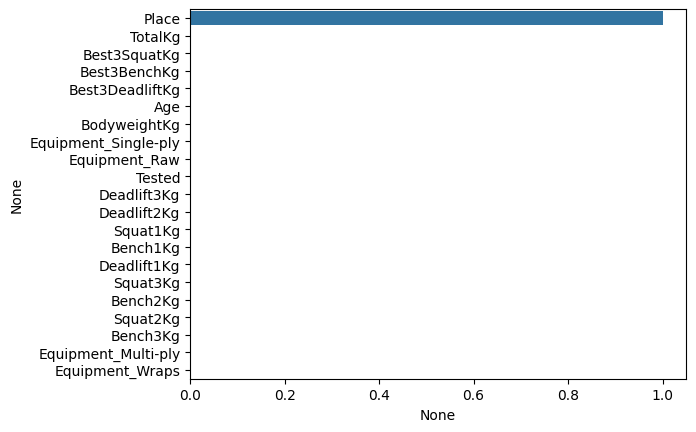

In [851]:
sns.barplot(y=importances.index, x=importances, orient="h")
pass